## Predicting Customer Behavior: Who will take out an Upstart loan?

Upstart is an online peer-to-peer lending company that handles hundreds of online applications a day. The goal of this notebook (as outlined in the accompanying proposal and slide deck) is to build a model that predicts whether or not an eligible Upstart applicant will end up taking out a loan or not. If we could determine which customers will take out loans and which won't, we can use that information to spend marketing budget across applicants in a smarter manner. We can also use this data to drive more eligible applicants to take out loans.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import sklearn
import seaborn as sns
import time
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import skew

# Import various componenet"s for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K

pd.set_option("display.max_columns", None)

Using TensorFlow backend.


### Reading-in data

Our data has about 1 million rows, pulled from an internal customer database. This customer database appends 6 lines at the end of every report pulled, so we'll remove those lines after reading in the data.

In [2]:
sfdc = pd.read_csv('files/sfdc-190302.csv', encoding='latin-1', low_memory=False)
sfdc = sfdc.drop(sfdc.tail(6).index)

In [3]:
sfdc.shape

(958996, 22)

### Test data

Before doing anything else, we will set aside the last 20% of customers to remain in our test set. We will only use the test set once we have a final model built, and all analysis and model tuning will be done using the remaining 80% of customers.

In [4]:
final_train, final_test = model_selection.train_test_split(sfdc,
                                                           test_size=.2,
                                                           random_state=420)

### Columns

The columns available from the data prior to cleaning are:
<br> <br>
'Most Recent Origination Date' - Date that a user took out a loan ("converted"). NA if no loan was taken out. <br>
'Most Recent Funding Agreement: Fraud Risk' - Did Upstart's internal fraud model predict a high likelihood of fraud? Y/N. <br>
'Most Recent Funding Agreement: Has Self Employed?' - Is the user self-employed? Self-reported. Y/N. <br>
'Most Recent Funding Agreement: DTI Percent' - A ratio of the user's debt on the credit report to their reported income. <br> 
'Time Zone' - Time zone of user's self-reported address. <br>
'UTM Source' - If user clicked a link to get to the Upstart website, this contains information on where they came from. Categorical. <br>
'Use of Funds' - Self-reported reason for wanting a loan. Categorical. <br>
'Partner ID' - If user was referred by an affiliate, this contains information on which affiliate referred them. Categorical. <br>
'Target Amount' - Either the loan amount that the user applied for or the maximum amount for which they qualify, whichever is larger. <br>
'Monthly Payment 3y' - If the user qualifies for a 3 year loan, this is their monthly payment for a 3 year term. NA otherwise. <br>
'Monthly Payment 5y' - If the user qualifies for a 5 year loan, this is their monthly payment for a 5 year term. NA otherwise. <br>
'Most Recent APR' - This is the interest rate for the user's loan based on their requested amount and loan term. NA if they do not qualify for a loan. <br>
'Number of self reported loans' - The number of other loans as reported by the applicant on their application. <br>
'Lending Program Name' - Upon application, each user's loan is assigned to a different lender. This is the lender they are assigned to. Categorical. <br>
'FICO Score' - A user's credit score, as pulled from their credit report. Theoretical range from 300-850. <br>
'Highest Degree Type' - Self-reported highest degree obtained. Categorical. <br>
'Citizenship' - Self-reported United States Citizenship status. Categorical. <br>
'Highest Reported Salary' - Self-reported salary. <br>
'Age' - Age. <br>
'Person Account: Mailing Zip/Postal Code' - Zip code of self-reported address. Categorical. <br>
'Person Account: Mailing State/Province' - State of self-reported address. Categorical. <br>
'Employment' - The name of their employer and their salary (as also stored in Highest Reported Salary). Categorical. <br>

### Cleaning

To clean the data for analysis, we'll focus on two things: removing NAs and one-hot encoding some of the categorical variables available. 
##### Removing NAs
Because we care about customers taking out loans, we will remove all users who are ineligible for a loan from our analysis and modelling. This is done by removing all rows where 'Most Recent APR' is NA. <br>
We'll remove NAs from 'Most Recent Origination Date' by turning it into a binary variable. If NA, it means the user never converted. Therefore a new column 'originated' will be True if 'Most Recent Origination Date' is not null, and False if it is null.<br>
Lastly, for now we'll mark all other NAs as -1. This applies to both 'Monthly Payment' fields, 'FICO Score', and 'DTI Percent'. I chose -1 because it is impossible for those fields to otherwise be negative.
##### One-hot encoding
For categorical variables with a reasonable number of categories (<20) we will one-hot encode them by creating new binary columns for each category. We will not be doing this for Zip Code because there are far too many zip codes.

In [5]:
sfdc_cleaned = pd.DataFrame()

sfdc_cleaned = pd.concat([sfdc_cleaned,
                          pd.get_dummies(final_train, 
                                         columns = ['Most Recent Funding Agreement: Fraud Risk', 
                                                    'Most Recent Funding Agreement: Has Self Employed?',
                                                    'Time Zone',
                                                    'UTM Source',
                                                    'Use of Funds',
                                                    'Partner ID',
                                                    'Lending Program Name',
                                                    'Highest Degree Type',
                                                    'Citizenship',
                                                    'Person Account: Mailing State/Province'
                                                   ])],
                         axis = 1)

sfdc_cleaned = sfdc_cleaned.dropna(subset = ['Most Recent APR'])
sfdc_cleaned['originated'] = ~final_train['Most Recent Origination Date'].isnull()

sfdc_cleaned = sfdc_cleaned.fillna(-1)

### Exploration

The first thing I wanted to see via exploration was the relationship between conversion and different features. Here, I divided the population by conversion status, then compare the distribution of APRs among the two populations. We can see an interesting spike in the bucket right before 30% APR – that's because there's a hard limit of 29.99% APR for all loans at Upstart. Any higher and the user no longer qualifies. 

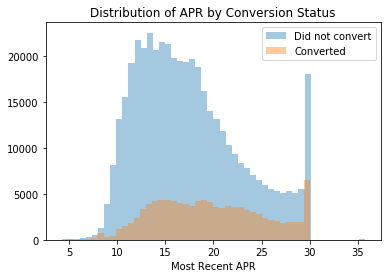

In [6]:
sns.distplot(sfdc_cleaned[sfdc_cleaned['originated'] == False]['Most Recent APR'], kde=False)
sns.distplot(sfdc_cleaned[sfdc_cleaned['originated'] == True]['Most Recent APR'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.title('Distribution of APR by Conversion Status')
plt.show()

If we remove the users with above a 29.5% APR, we see a smoother distribution on the tail end. We also see that a higher proportion of high APR users get loans compared to the low APR users. For APRs 20% or higher, 24.6% of users end up getting a loan. Below 20% APR, only 13.4% of users convert.

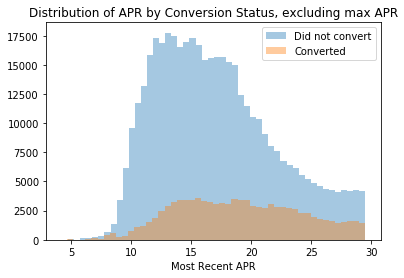

In [7]:
sns.distplot(sfdc_cleaned[(sfdc_cleaned['originated'] == False) & (sfdc_cleaned['Most Recent APR'] <= 29.5)]['Most Recent APR'], kde=False)
sns.distplot(sfdc_cleaned[(sfdc_cleaned['originated'] == True) & (sfdc_cleaned['Most Recent APR'] <= 29.5)]['Most Recent APR'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.title('Distribution of APR by Conversion Status, excluding max APR')
plt.show()

In [8]:
sfdc_cleaned[(sfdc_cleaned['Most Recent APR'] < 20)]['originated'].value_counts()

False    318326
True      57575
Name: originated, dtype: int64

In [9]:
sfdc_cleaned[(sfdc_cleaned['Most Recent APR'] >= 20)]['originated'].value_counts()

False    130493
True      47422
Name: originated, dtype: int64

Next I look at the relationship between Monthly Payment and Conversion Status. The most interesting takeaway here is that a very high proportion of users who don't qualify for a certain term seem to convert. Of users who either don't qualify for a 3 year or a 5 year loan (but qualify for the other), 69.5% of users converted. 

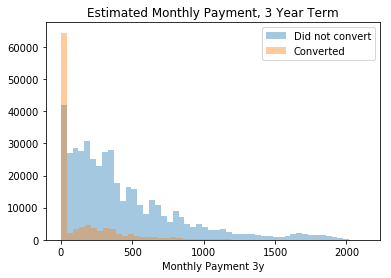

In [10]:
sns.distplot(sfdc_cleaned[sfdc_cleaned['originated'] == False]['Monthly Payment 3y'], kde=False)
sns.distplot(sfdc_cleaned[sfdc_cleaned['originated'] == True]['Monthly Payment 3y'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.title('Estimated Monthly Payment, 3 Year Term')
plt.show()

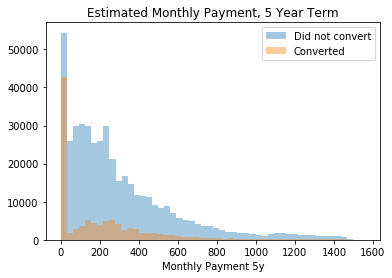

In [11]:
sns.distplot(sfdc_cleaned[sfdc_cleaned['originated'] == False]['Monthly Payment 5y'], kde=False)
sns.distplot(sfdc_cleaned[sfdc_cleaned['originated'] == True]['Monthly Payment 5y'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.title('Estimated Monthly Payment, 5 Year Term')
plt.show()

In [12]:
sfdc_cleaned[((sfdc_cleaned['Monthly Payment 5y'] < 0) | (sfdc_cleaned['Monthly Payment 3y'] < 0))]['originated'].value_counts()

True     102462
False     45032
Name: originated, dtype: int64

The last thing I look at is FICO Score and Income. They don't seem to have a strong correlation, as the top FICO Scores exist across all bands of Salary, but there is a tendency for the lowest FICO Scores to be among those with low income. Both income and FICO have normal-ish distributions, but we can see that the skewness of the originated distribution leans towards the lower end – meaning those with lower income and FICOs are more likely to originate a loan than those with high income and high FICO.

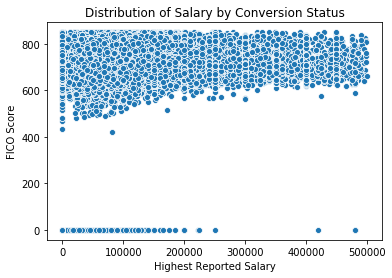

In [13]:
sns.scatterplot(y = 'FICO Score', x = 'Highest Reported Salary', data = sfdc_cleaned[(sfdc_cleaned['originated'] == False) & (sfdc_cleaned['Highest Reported Salary'] < 500000)])
plt.title('Distribution of Salary by Conversion Status')
plt.show()

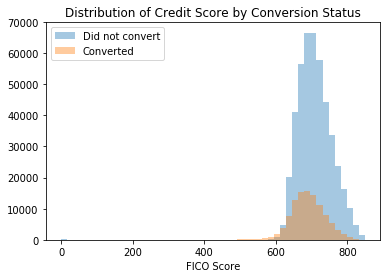

In [14]:
sns.distplot(sfdc_cleaned[sfdc_cleaned['originated'] == False]['FICO Score'], kde=False)
sns.distplot(sfdc_cleaned[sfdc_cleaned['originated'] == True]['FICO Score'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.title('Distribution of Credit Score by Conversion Status')
plt.show()

In [15]:
print('Skewness of Non-originating population:')
print(skew(sfdc_cleaned[sfdc_cleaned['originated'] == False]['FICO Score']))
print('Skewness of originating population')
print(skew(sfdc_cleaned[sfdc_cleaned['originated'] == True]['FICO Score']))

Skewness of Non-originating population:
-1.7401044615741423
Skewness of originating population
-0.46154040061114565


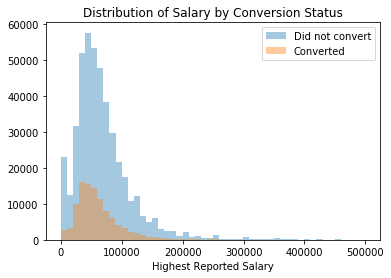

In [16]:
sns.distplot(sfdc_cleaned[(sfdc_cleaned['originated'] == False) & (sfdc_cleaned['Highest Reported Salary'] < 500000)]['Highest Reported Salary'], kde=False)
sns.distplot(sfdc_cleaned[(sfdc_cleaned['originated'] == True) & (sfdc_cleaned['Highest Reported Salary'] < 500000)]['Highest Reported Salary'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.title('Distribution of Salary by Conversion Status')
plt.show()

In [17]:
print('Skewness of Non-originating population:')
print(skew(sfdc_cleaned[(sfdc_cleaned['originated'] == False) & (sfdc_cleaned['Highest Reported Salary'] < 500000)]['Highest Reported Salary']))
print('Skewness of originating population')
print(skew(sfdc_cleaned[(sfdc_cleaned['originated'] == True) & (sfdc_cleaned['Highest Reported Salary'] < 500000)]['Highest Reported Salary']))

Skewness of Non-originating population:
2.4719940114641124
Skewness of originating population
2.515894481916155


### Principal Components Analysis

Before doing PCA, we'll further split our training data into a new training and test set for validation. We'll also normalize the features as part of the PCA process.

In [92]:
labels = np.where(sfdc_cleaned['originated'], 1, 0)
features = sfdc_cleaned.drop(['originated', 
                              'Most Recent Origination Date', 
                              'Person Account: Mailing Zip/Postal Code',
                              'Employment',
                              'Most Recent APR'], axis=1)
features = features.fillna(0)

In [93]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(features,
                                                                    labels,
                                                                    test_size=.2,
                                                                    random_state=420)

In [20]:
#normalize and scale
x_train_norm = preprocessing.normalize(x_train)

In [21]:
sklearn_pca = PCA(2)
x_pca = sklearn_pca.fit_transform(x_train_norm)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.92542272 0.06575885]


These PCA results show that 92.5% of the variance in the data is explained by one principal component. This intuitively makes sense, since a lot of the features relate to one another. For example, Monthly Payment is a function of one's APR and their Target Amount. APR is affected by one's FICO, and one's FICO is affected by their DTI. Everything is linked but not necessarily correlated, so this might be why one principal component explains such a high amount of variance.

In [22]:
## Adding columns to the training data based on PC value.

pca1 = [x[0] for x in x_pca]
x_train['pca1'] = pca1
pca2 = [x[1] for x in x_pca]
x_train['pca2'] = pca2

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Below, it looks like conversion status isn't closely related to the first principal component. There isn't a noticeably higher proportion of converts for any principal component value. FICO Score and Monthly Payment 3y also don't seem to have a strong correlation with PC1.

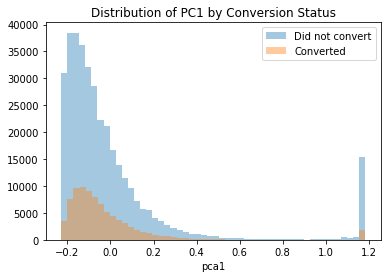

In [23]:
sns.distplot(x_train[y_train == 0]['pca1'], kde=False)
sns.distplot(x_train[y_train == 1]['pca1'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.title('Distribution of PC1 by Conversion Status')
plt.show()

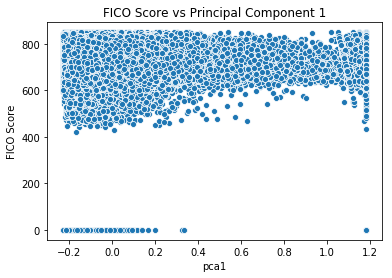

In [24]:
sns.scatterplot(x='pca1', y='FICO Score', data=x_train)
plt.title('FICO Score vs Principal Component 1')
plt.show()

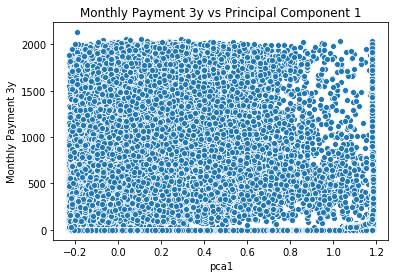

In [25]:
sns.scatterplot(x='pca1', y='Monthly Payment 3y', data=x_train)
plt.title('Monthly Payment 3y vs Principal Component 1')
plt.show()

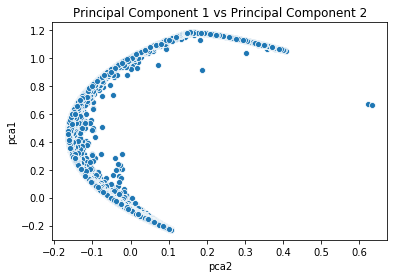

In [26]:
sns.scatterplot(x='pca2', y='pca1', data=x_train)
plt.title('Principal Component 1 vs Principal Component 2')
plt.show()

### Logistic Regression

The first model we'll try is a Logistic Regression. It's a simple model and it's easy to set up so it should give us a good idea of what we're dealing with and how predictable this dataset is. Again we'll split the data up into training and validation sets so we know how good of a job it's doing. The baseline we need to beat is 79.7%, which is the percentage of applicants who do not convert. If the model doesn't do better than this, then it would be more accurate to predict that no customers will convert.

In [94]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(features,
                                                                    labels,
                                                                    test_size=.2,
                                                                    random_state=420)

In [95]:
print('The percentage of customers who do not convert in the training data:')
print(1 - (np.bincount(y_train)[1] / (np.bincount(y_train)[1] + np.bincount(y_train)[0])))

The percentage of customers who do not convert in the training data:
0.8101532100069517


In [29]:
lr = LogisticRegression(solver='liblinear')

lr = lr.fit(x_train, y_train)

score = cross_val_score(lr, x_train, y_train, cv=10)

In [30]:
print('Scores across 10 cross-validation folds:')
print(score)
print('Standard deviation of scores:')
print(score.std())
print('Average score:')
print(score.mean())

Scores across 10 cross-validation folds:
[0.85085541 0.85162281 0.85121318 0.85173231 0.85477937 0.85863898
 0.85272543 0.85322198 0.85371854 0.85482451]
Standard deviation of scores:
0.0022162843748619056
Average score:
0.8533332525037363


The Logistic Regression was able to beat the baseline with a average cross-validation score of 86.4% across 10 folds. The standard deviation is .2%, meaning it had pretty consistent performance across the board.

In [89]:
lr.score(x_test, y_test)

0.8523166371745332

In [31]:
pd.DataFrame({
    'feature':x_train.columns,
    'coef':lr.coef_[0]
}).sort_values('coef')[:5]

,feature,coef
3,Monthly Payment 5y,-0.008436
2,Monthly Payment 3y,-0.008038
5,FICO Score,-0.001517
7,Age,-0.000563
8,Most Recent Funding Agreement: Fraud Risk_High,-0.000024


The most important features seem to be the Monthly Payment variables, followed by FICO Score. It's interesting that Monthly Payment is so important given it's a function of other features that aren't as important, like APR and Target Amount. 

### Neural Network

The next model we'll try is a Neural Network. I exploratorily tried several different layer depths and widths and the best performance I got was using the structure below. 

In [32]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
model.add(Dense(2048, activation='relu', input_shape=(314,)))
model.add(Dropout(.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(4, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              645120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
__________

In [33]:
history = model.fit(x_train, y_train,
                    batch_size=2056,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 443052 samples, validate on 110764 samples
Epoch 1/10
443052/443052 [==============================] - 43s 98us/step - loss: 3.3886 - acc: 0.7520 - val_loss: 3.0391 - val_acc: 0.8114
Epoch 2/10
443052/443052 [==============================] - 43s 97us/step - loss: 2.2568 - acc: 0.8101 - val_loss: 3.0391 - val_acc: 0.8114
Epoch 3/10
443052/443052 [==============================] - 39s 88us/step - loss: 2.2403 - acc: 0.8101 - val_loss: 3.0391 - val_acc: 0.8114
Epoch 4/10
443052/443052 [==============================] - 40s 91us/step - loss: 2.2330 - acc: 0.8101 - val_loss: 3.0391 - val_acc: 0.8114
Epoch 5/10
443052/443052 [==============================] - 39s 88us/step - loss: 2.2335 - acc: 0.8101 - val_loss: 3.0391 - val_acc: 0.8114
Epoch 6/10
443052/443052 [==============================] - 39s 88us/step - loss: 2.2314 - acc: 0.8098 - val_loss: 3.0391 - val_acc: 0.8114
Epoch 7/10
443052/443052 [==============================] - 39s 88us/step - loss: 2.2263 - acc: 0.8101 - val

The Neural Network outperforms the baseline but the performance isn't meaningfully better than the Logistic Regression. Neural Networks thrive with complex unstructured data, and they require a lot of in-depth tuning to work properly. There may be potential to use a NN on this dataset, but let's try Random Forests first.

### Random Forest Classifier

We'll use the same features and now use them in a Random Forest Classifier. We'll use 100 trees in our forest as this is a large dataset, and we just want to get an initial sense of how well a Random Forest will perform before tuning it.

In [34]:
start_time = time.time()
rf2 = RandomForestClassifier(n_estimators = 100,
                             class_weight = 'balanced',
                             n_jobs = -1)

rf2 = rf2.fit(x_train, y_train)

rf_test2 = rf2.score(x_train, y_train)
rf_score2 = cross_val_score(rf2, x_train, y_train, cv=10)
finish_time = time.time() - start_time

In [35]:
print('Scores across 10 cross-validation folds:')
print(rf_score2)
print('Standard deviation of scores:')
print(rf_score2.std())
print('Average score:')
print(rf_score2.mean())

Scores across 10 cross-validation folds:
[0.962601   0.9619916  0.96257759 0.96363842 0.96250987 0.96269044
 0.96438325 0.96325471 0.96348042 0.96329985]
Standard deviation of scores:
0.0006617289725154184
Average score:
0.9630427161886785


The Random Forest performed considerably better than the Logistic Regression in terms of average cross validation score and standard deviation. It was more consistent across folds and more accurate. For this reason, we'll proceed with a Random Forest Classifier and see if we can tune it to be even better. First we will look at the predicted probabilities from the Random Forest model and see if there is anything to learn.

In [36]:
y_predict2 = rf2.predict_proba(x_train)
y_predict2 = ([x[1] for x in y_predict2])

Below we can see that the predicted probabilities of conversion are very polarized – the model is either certain they won't convert or fairly certain they will.

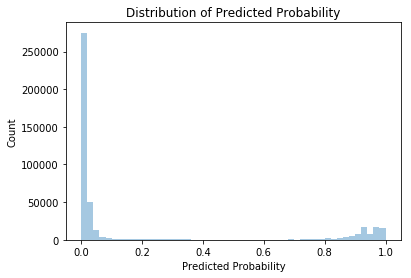

In [37]:
sns.distplot(y_predict2, kde=False)
plt.title('Distribution of Predicted Probability')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.show()

Here we can see that Monthly Payment continues to be the most important feature in the model. FICO isn't as important as it was in the Logistic Regression, but being a Low Fraud Risk has an increased level of importance.

In [38]:
pd.DataFrame({
    'feature':x_train.columns,
    'importance':rf2.feature_importances_
}).sort_values('importance', ascending=False)[:5]

,feature,importance
2,Monthly Payment 3y,0.294543
3,Monthly Payment 5y,0.217600
9,Most Recent Funding Agreement: Fraud Risk_Low,0.134601
0,Most Recent Funding Agreement: DTI Percent,0.032816
5,FICO Score,0.032334


The one-hot encoded categorical variables add a lot of additional features to the model, many of which might just contain noise. One-hot encoded categorical features also don't work well with Random Forests, since the trees are generated by a random sample of features and probably won't contain the full range of one-hot encoded features. For these reasons, we'll remove the categorical variables from our model entirely and see how it affects performance.

In [39]:
### Same cleaning pipeline as last time, except no one-hot encoded features are generated.

sfdc_nocat = pd.DataFrame()

sfdc_nocat = final_train.drop(['Most Recent Funding Agreement: Fraud Risk',
                         'Most Recent Funding Agreement: Has Self Employed?',
                         'Time Zone',
                         'UTM Source',
                         'Use of Funds',
                         'Partner ID',
                         'Lending Program Name',
                         'Highest Degree Type',
                         'Citizenship',
                         'Person Account: Mailing State/Province',
                         'Most Recent Origination Date',
                         'Employment',
                         'Person Account: Mailing Zip/Postal Code'],
                       axis=1)

sfdc_nocat['originated'] = ~final_train['Most Recent Origination Date'].isnull()
sfdc_nocat = sfdc_nocat.dropna(subset = ['Most Recent APR'])

sfdc_nocat = sfdc_nocat.fillna(-1)

In [40]:
labels = np.where(sfdc_nocat['originated'], 1, 0)
features = sfdc_nocat.drop(['originated'], axis=1)
features = features.fillna(0)

In [41]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(features,
                                                                    labels,
                                                                    test_size=.2,
                                                                    random_state=420)

In [42]:
start_time = time.time()
rf3 = RandomForestClassifier(n_estimators = 100,
                             class_weight = 'balanced',
                             n_jobs = -1)

rf3 = rf3.fit(x_train, y_train)

rf_test3 = rf3.score(x_train, y_train)
rf_score3 = cross_val_score(rf3, x_train, y_train, cv=10)
finish_time = time.time() - start_time

In [43]:
print('Scores across 10 cross-validation folds:')
print(rf_score3)
print('Standard deviation of scores:')
print(rf_score3.std())
print('Average score:')
print(rf_score3.mean())

Scores across 10 cross-validation folds:
[0.95756782 0.95783867 0.95910168 0.95860512 0.9561449  0.95813114
 0.95860512 0.95643833 0.95851484 0.95921454]
Standard deviation of scores:
0.0009896356392663779
Average score:
0.9580162162137654


The performance is very similar to the Random Forest model that included categorical variables, perhaps suggesting that the categorical variables provided little value.

In [44]:
pd.DataFrame({
    'feature':x_train.columns,
    'importance':rf3.feature_importances_
}).sort_values('importance', ascending=False)[:5]

,feature,importance
2,Monthly Payment 3y,0.461566
3,Monthly Payment 5y,0.326552
4,Most Recent APR,0.054276
0,Most Recent Funding Agreement: DTI Percent,0.045799
6,FICO Score,0.029670


One of the categorical variables we removed previously had an importance of around .13. Now that it's been removed, it looks like both Monthly Payment variables have had their importance increased as a result. FICO and DTI percent are still relatively the same, but Most Recent APR has been added into the top five important features. This isn't too much of a surprise given the relationship between conversion and APR that we saw earlier, where those with high APRs were more likely to convert.

Let's try adding back Fraud Risk variables, since they were the third highest importance in the first iteration. We'll still keep out all of the other categorical variables but we'll add that one back since it's potentially not noise.

In [45]:
sfdc_nocat2 = pd.DataFrame()

sfdc_nocat2 = pd.concat([sfdc_nocat2,
                         pd.get_dummies(final_train, 
                                        columns = ['Most Recent Funding Agreement: Fraud Risk'])],
                         axis = 1)

sfdc_nocat2 = sfdc_nocat2.dropna(subset = ['Most Recent APR'])
sfdc_nocat2['originated'] = ~final_train['Most Recent Origination Date'].isnull()

sfdc_nocat2 = sfdc_nocat2.fillna(-1)

In [46]:
labels = np.where(sfdc_nocat2['originated'], 1, 0)
features = sfdc_nocat2.drop(['originated', 
                             'Most Recent Funding Agreement: Has Self Employed?',
                             'Time Zone',
                             'UTM Source',
                             'Use of Funds',
                             'Partner ID',
                             'Lending Program Name',
                             'Highest Degree Type',
                             'Citizenship',
                             'Person Account: Mailing State/Province',
                             'Most Recent Origination Date',
                             'Employment',
                             'Person Account: Mailing Zip/Postal Code'], axis=1)
features = features.fillna(0)

In [47]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(features,
                                                                    labels,
                                                                    test_size=.2,
                                                                    random_state=420)

In [48]:
start_time = time.time()
rf4 = RandomForestClassifier(n_estimators = 100,
                             class_weight = 'balanced',
                             n_jobs = -1)

rf4 = rf4.fit(x_train, y_train)

rf_test4 = rf4.score(x_train, y_train)
rf_score4 = cross_val_score(rf4, x_train, y_train, cv=10)
finish_time = time.time() - start_time

In [49]:
print('Scores across 10 cross-validation folds:')
print(rf_score4)
print('Standard deviation of scores:')
print(rf_score4.std())
print('Average score:')
print(rf_score4.mean())

Scores across 10 cross-validation folds:
[0.96939466 0.97068117 0.97131249 0.97158334 0.9699131  0.97092879
 0.97083851 0.96982282 0.97128992 0.97151563]
Standard deviation of scores:
0.0007297449085641232
Average score:
0.9707280440676307


This is the best performing iteration of the Random Forest Classifier so far, so we'll use this one. Let's first use a Randomized Search Grid to improve the parameter choices, then use another Search Grid based on those results to fine tune.

### Hyperparameter Tuning

In [50]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [51]:
rf_r = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf_r,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose = 2,
                               random_state = 420,
                               n_jobs = -1
                              )
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 293.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 638.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=420, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [52]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [53]:
rf_bestrand = RandomForestClassifier(**rf_random.best_params_)

rf_bestrand = rf_bestrand.fit(x_train, y_train)

rf_test_bestrand = rf_bestrand.score(x_train, y_train)
rf_score_bestrand = cross_val_score(rf_bestrand, x_train, y_train, cv=10)
finish_time = time.time() - start_time

In [54]:
print(finish_time)
print(rf_test_bestrand)
print(rf_score_bestrand.std())
print(rf_score_bestrand.mean())

48062.4246339798
0.9832299594629975
0.0007354870932910901
0.9710620896982034


In [55]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1500, stop = 2100, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 110, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True]

grid_search = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [56]:
rf_gs = RandomForestClassifier()

rf_gs = RandomizedSearchCV(estimator = rf_gs,
                               param_distributions = grid_search,
                               cv = 5,
                               verbose = 2,
                               random_state = 420,
                               n_jobs = -1
                              )
rf_gs.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 110.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 241.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [1500, 1512, 1524, 1536, 1548, 1561, 1573, 1585, 1597, 1610, 1622, 1634, 1646, 1659, 1671, 1683, 1695, 1708, 1720, 1732, 1744, 1757, 1769, 1781, 1793, 1806, 1818, 1830, 1842, 1855, 1867, 1879, 1891, 1904, 1916, 1928, 1940, 1953, 1965, 1977, 1989, 2002, 2014, 2026, 2038, 2051, 2063, 2075, 2087, 2100], 'max_features': ['auto', 'sqrt'], 'max_depth': [50, 65, 80, 95, 110], 'min_samples_

In [57]:
rf_gs.best_params_

{'n_estimators': 1622,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

In [58]:
rf_hyp = RandomForestClassifier(**rf_gs.best_params_,
                               n_jobs=-1)
rf_hyp.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=30,
            min_weight_fraction_leaf=0.0, n_estimators=1622, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
rf_hyp_cv = cross_val_score(rf_hyp, x_train, y_train, cv=10)

In [60]:
rf_hyp_cv

array([0.9698235 , 0.97115515, 0.97144792, 0.97162848, 0.97031938,
       0.9715382 , 0.97117707, 0.97004853, 0.97108678, 0.97217018])

In [61]:
print(rf_hyp_cv.mean())
print(rf_hyp_cv.std())
print(rf_hyp.score(x_test, y_test))

0.9710395192898126
0.000710960731340103
0.9718590877902568


After hyperparameter-tuning the model, average performance improved from .9707 to .9719 across 10-folds. Not a negligible increase but fairly small. Now that we have a winning model, let's look at the feature importances and look at the predictions on validation data before moving on to test data.

In [62]:
hyp_importances = pd.DataFrame({
    'feature':x_train.columns, 
    'importance':rf_hyp.feature_importances_}).sort_values('importance', ascending=False)[:7]

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


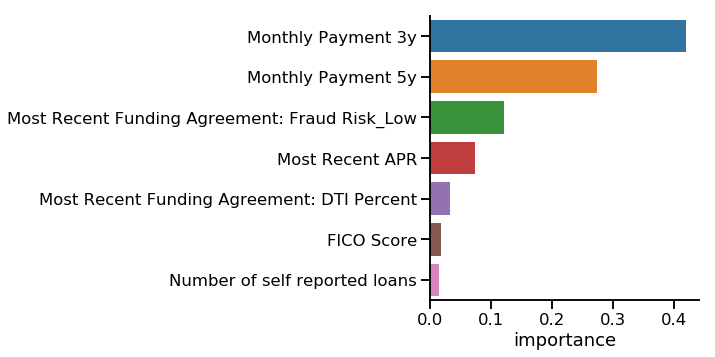

In [63]:
sns.set_context("talk")
sns.catplot(x='importance', y='feature', data=hyp_importances, kind='bar')
plt.xlabel('importance')
plt.ylabel('')
plt.show()

In [64]:
predictions = rf_hyp.predict_proba(x_test)
predictions = [x[1] for x in predictions]

In [65]:
combined_test_df = x_test.copy()
combined_test_df['actual'] = y_test
combined_test_df['predicted'] = predictions

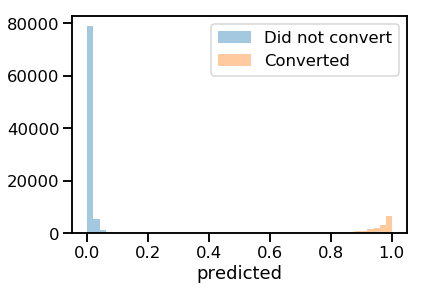

In [66]:
sns.set_context('talk')
sns.distplot(combined_test_df[combined_test_df['actual'] == False]['predicted'], kde=False)
sns.distplot(combined_test_df[combined_test_df['actual'] == True]['predicted'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.show()

In [67]:
pd.crosstab(y_test, rf_hyp.predict(x_test), margins=True, rownames = ['Actuals'], colnames = ['Predicted'])

Predicted,0,1,All
Actuals,,,
0,88034,1845,89879
1,1272,19613,20885
All,89306,21458,110764


The most important features seem to be the Monthly Payment features, which is consistent with what we saw in the Logistic Regression model. The crosstab shows that the model underpredicts conversions among converters at a worse rate than it overpredicts them among non-converters, but it does both at a relatively low rate. This model seems to be ready to introduce to the test data.

### Test Data

In [78]:
# This is the same cleaning process that occurred with the training data right before our final model iteration.

# One-hot encode the Fraud Risk categories
sfdc_test = pd.get_dummies(final_test, 
                           columns = ['Most Recent Funding Agreement: Fraud Risk'])

# Drop ineligible users
sfdc_test = sfdc_test.dropna(subset = ['Most Recent APR'])
# Convert origination date to a binary variable
sfdc_test['originated'] = ~final_test['Most Recent Origination Date'].isnull()

# Fill NAs with -1
sfdc_test = sfdc_test.fillna(-1)

In [79]:
labels = np.where(sfdc_test['originated'], 1, 0)
features = sfdc_test.drop(['originated', 
                             'Most Recent Funding Agreement: Has Self Employed?',
                             'Time Zone',
                             'UTM Source',
                             'Use of Funds',
                             'Partner ID',
                             'Lending Program Name',
                             'Highest Degree Type',
                             'Citizenship',
                             'Person Account: Mailing State/Province',
                             'Most Recent Origination Date',
                             'Employment',
                             'Person Account: Mailing Zip/Postal Code'], axis=1)
features = features.fillna(0)

In [80]:
rf_hyp.score(features, labels)

0.9712268059809044

The prediction score on the test data is almost identical to what we saw on the 10-fold cross validation. This consistency is good and the accuracy is much higher than our baseline of 81% and the LogReg and NN models. Let's look at the confusion matrix and distribution of prediction probabilities. 

In [81]:
pd.crosstab(labels, 
            rf_hyp.predict(features), 
            margins=True, 
            rownames = ['Actuals'], 
            colnames = ['Predicted']
           )

Predicted,0,1,All
Actuals,,,
0,109802,2390,112192
1,1603,24980,26583
All,111405,27370,138775


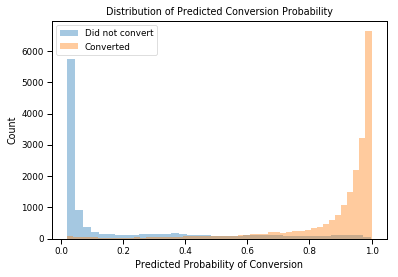

In [100]:
sns.set_context(context = 'paper')
sns.distplot(combined_test_df[(combined_test_df['actual'] == False) & (combined_test_df['predicted'] > .02)]['predicted'], kde=False)
sns.distplot(combined_test_df[(combined_test_df['actual'] == True) & (combined_test_df['predicted'] > .02)]['predicted'], kde=False)
plt.legend(['Did not convert','Converted'])
plt.xlabel('Predicted Probability of Conversion')
plt.ylabel('Count')
plt.title('Distribution of Predicted Conversion Probability')
plt.show()

In [109]:
len(combined_test_df[(combined_test_df['actual'] == False) & (combined_test_df['predicted'] > .33)])

2674

The confusion matrix looks identical to what we saw earlier, where false positives occur at a lower rate than false negatives on conversion. Interestingly, the model is either very certain that a user will convert, or very certain that they won't. It assigns either a very high probability or a very low probability, with relatively few users in the middle. This is a good thing, as it suggests the model is sure about the outcome of its predictions. I would say this model is ready to be used to predict conversions of future customers.

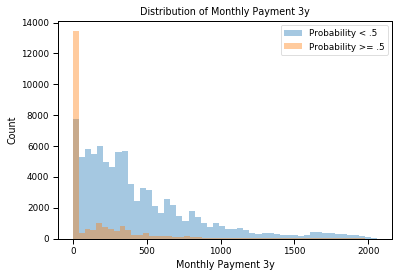

In [101]:
sns.set_context(context = 'paper')
sns.distplot(combined_test_df[(combined_test_df['predicted'] < .5)]['Monthly Payment 3y'], kde=False)
sns.distplot(combined_test_df[(combined_test_df['predicted'] >= .5)]['Monthly Payment 3y'], kde=False)
plt.legend(['Probability < .5', 'Probability >= .5'])
plt.xlabel('Monthly Payment 3y')
plt.ylabel('Count')
plt.title('Distribution of Monthly Payment 3y')
plt.show()

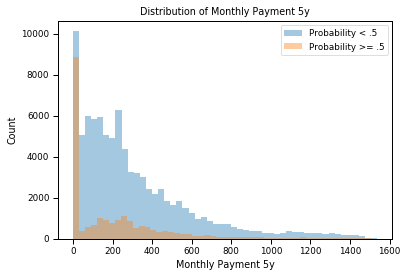

In [102]:
sns.set_context(context = 'paper')
sns.distplot(combined_test_df[(combined_test_df['predicted'] < .5)]['Monthly Payment 5y'], kde=False)
sns.distplot(combined_test_df[(combined_test_df['predicted'] >= .5)]['Monthly Payment 5y'], kde=False)
plt.legend(['Probability < .5', 'Probability >= .5'])
plt.xlabel('Monthly Payment 5y')
plt.ylabel('Count')
plt.title('Distribution of Monthly Payment 5y')
plt.show()

### Appendix: What if we imputed NAs for Monthly Payment differently?

In [68]:
sfdc_impute = pd.DataFrame()
sfdc_impute = final_train.drop(['Most Recent Funding Agreement: Fraud Risk',
                         'Most Recent Funding Agreement: Has Self Employed?',
                         'Time Zone',
                         'UTM Source',
                         'Use of Funds',
                         'Partner ID',
                         'Lending Program Name',
                         'Highest Degree Type',
                         'Citizenship',
                         'Person Account: Mailing State/Province',
                         'Most Recent Origination Date',
                         'Employment',
                         'Person Account: Mailing Zip/Postal Code'],
                       axis=1)
sfdc_impute['originated'] = ~final_train['Most Recent Origination Date'].isnull()
sfdc_impute = sfdc_impute.dropna(subset = ['Most Recent APR'])
sfdc_impute = sfdc_impute[sfdc_impute['Most Recent APR'] <= 29]

In [69]:
sfdc_impute.fillna(value={
    'Monthly Payment 3y': sfdc_impute['Monthly Payment 3y'].mean(),
    'Monthly Payment 5y': sfdc_impute['Monthly Payment 5y'].mean(),
    'Number of self reported loans': 0,
    'FICO Score': sfdc_impute['FICO Score'].mean(),
    'Most Recent Funding Agreement: DTI Percent': 0
}, inplace=True)

In [70]:
labels = np.where(sfdc_impute['originated'], 1, 0)
features = sfdc_impute.drop(['originated'], axis=1)
features = features.fillna(0)

In [71]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(features,
                                                                    labels,
                                                                    test_size=.2,
                                                                    random_state=420)

In [72]:
start_time = time.time()
rf_impute = RandomForestClassifier(n_estimators = 100,
                             class_weight = 'balanced',
                             n_jobs = -1)

rf_impute = rf_impute.fit(x_train, y_train)

rf_test_impute = rf_impute.score(x_train, y_train)
rf_score_impute = cross_val_score(rf_impute, x_train, y_train, cv=10)
finish_time = time.time() - start_time

In [73]:
print(finish_time)
print(rf_score_impute)
print(rf_score_impute.std())
print(rf_score_impute.mean())

237.77393198013306
[0.96760264 0.96652829 0.96609886 0.96621815 0.96648058 0.9670293
 0.96464357 0.96617044 0.96547775 0.96762496]
0.0008646552803997459
0.9663874546714013


In [74]:
pd.DataFrame({
    'feature':x_train.columns, 
    'importance':rf_impute.feature_importances_}).sort_values('importance', ascending=False)[:7]

,feature,importance
2,Monthly Payment 3y,0.473800
3,Monthly Payment 5y,0.324461
0,Most Recent Funding Agreement: DTI Percent,0.054955
4,Most Recent APR,0.045652
1,Target Amount,0.038719
6,FICO Score,0.025465
7,Highest Reported Salary,0.018392
